# Import Packages

In [0]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix,mean_squared_error
import tensorflow as tf
import random as rn
import os
from tensorflow.keras import optimizers,backend as K
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation,BatchNormalization, CuDNNLSTM
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

# Function Definition

In [0]:
def build_timeseries(mat, y_col_index,TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    return x, y


def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat


def mape(y_true, y_pred): 
  '''
  Function to calculate MAPE
  '''
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def adjusted_mape(y_true, y_pred): 
  '''
  Function to calculate Adjusted MAPE
  '''
  y_true_after = y_true[1:]
  y_true_before = y_true[:-1]
  y_pred_after = y_pred[1:]
  y_pred_before = y_pred[:-1]

  y_true_label = (pd.Series(y_true_after)-pd.Series(y_true_before)).apply(lambda x: 1 if x>0 else 0)
  y_pred_label = (pd.Series(y_pred_after)-pd.Series(y_pred_before)).apply(lambda x: 1 if x>0 else 0)

  adjustment_constant = np.abs(y_true_label-y_pred_label).apply(lambda x: 2 if x==1 else 1).tolist()
  adjustment_constant.insert(0,1)

  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / (2*y_true)) * adjustment_constant) * 100


def cross_val(df,TIME_STEPS,BATCH_SIZE,n_fold,input_dropout,hidden_dropout,l2_regularizer,lstm_units_1,lstm_units_2,hidden_units_1,hidden_units_2,optimizer,epochs):
  '''
  TIME_STEPS: how many time steps before which used as predictor
  BATCH_SIZE: how long is a "season" period
  '''
  tscv = TimeSeriesSplit(n_splits=n_fold)
  mape_list=[]
  adj_mape_list=[]
  acc_list = []
  scaler=MinMaxScaler(feature_range=(0,1))
  for train_index, val_index in tscv.split(df):
    print("#Train Samples: ", len(train_index), "#Val Samples: ", len(val_index))
    df_train_raw,df_val_raw=df.loc[train_index,:],df.loc[val_index,:]

    #Rescaling
    df_train_scaled=scaler.fit_transform(df_train_raw)
    df_val_scaled=scaler.transform(df_val_raw)

    #Reformatting Data
    x_t, y_t = build_timeseries(df_train_scaled, 3,TIME_STEPS)
    x_t = trim_dataset(x_t, BATCH_SIZE)
    y_t = trim_dataset(y_t, BATCH_SIZE)
    x_val, y_val = build_timeseries(df_val_scaled, 3,TIME_STEPS)
    x_val = trim_dataset(x_val, BATCH_SIZE)
    y_val = trim_dataset(y_val, BATCH_SIZE)

    #Model Build
    model=Sequential()
    model.add(Input(batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2])))
    model.add(Dropout(input_dropout))
    model.add(CuDNNLSTM(units = lstm_units_1, return_sequences=True, kernel_initializer='random_uniform'))
    model.add(Dropout(hidden_dropout))
    model.add(CuDNNLSTM(units = lstm_units_2))
    model.add(Dropout(hidden_dropout))
    model.add(Dense(hidden_units_1,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer)))
    model.add(Activation('relu'))
    model.add(Dropout(hidden_dropout))
    model.add(Dense(hidden_units_2,kernel_regularizer=regularizers.l2(l2_regularizer),activity_regularizer=regularizers.l2(l2_regularizer)))
    model.add(Activation('relu'))
    model.add(Dropout(hidden_dropout))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',optimizer=optimizer,metrics=['mape']) 

    history=model.fit(x_t, y_t,
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    epochs=epochs,
                    verbose=False,
                    validation_data=(trim_dataset(x_val, BATCH_SIZE),trim_dataset(y_val, BATCH_SIZE)))

    y_pred = model.predict(trim_dataset(x_val, BATCH_SIZE), batch_size=BATCH_SIZE)
    y_pred = y_pred.flatten()
    # convert the predicted value to range of real data
    y_pred_org = (y_pred * scaler.data_range_[3]) + scaler.data_min_[3]
    # min_max_scaler.inverse_transform(y_pred)
    y_val_t_org = (y_val * scaler.data_range_[3]) + scaler.data_min_[3]

    MAPE=mape(y_val_t_org, y_pred_org)
    mape_list.append(MAPE)
    print('Val MAPE: ',MAPE)

    adj_MAPE=adjusted_mape(y_val_t_org, y_pred_org)
    adj_mape_list.append(adj_MAPE)
    print('Val Adjusted MAPE: ',adj_MAPE)

    window=7

    y_pred_confusion=y_pred_org.tolist()
    y_pred_after_confusion=y_pred_confusion[window:]
    y_pred_before_confusion=y_pred_confusion[:-window]
    is_bullish_pred=(pd.Series(y_pred_after_confusion)-pd.Series(y_pred_before_confusion)).apply(lambda x: 1 if x>0 else 0)

    y_val_confusion=y_val_t_org.tolist()
    y_val_after_confusion=y_val_confusion[window:]
    y_val_before_confusion=y_val_confusion[:-window]
    is_bullish_val=(pd.Series(y_val_after_confusion)-pd.Series(y_val_before_confusion)).apply(lambda x: 1 if x>0 else 0)

    confusion=confusion_matrix(is_bullish_pred,is_bullish_val)
    acc=(confusion[0][0]+confusion[1][1])/(confusion[0][0]+confusion[0][1]+confusion[1][0]+confusion[1][1])
    acc_list.append(acc)

    print('Val Accuracy: ',acc)

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    print('')
    print('')

    #Plot Prediction Result
    plt.figure()
    plt.plot(y_pred_org)
    plt.plot(y_val_t_org)
    plt.title('Prediction vs Real Stock Price')
    plt.ylabel('Price ($)')
    plt.xlabel('Timesteps')
    plt.legend(['Prediction', 'Real'], loc='upper left')
    plt.show()

    #Plot Prediction Result - Bahasa Indonesia
    plt.figure()
    plt.plot(y_pred_org)
    plt.plot(y_val_t_org)
    plt.title('Perbandingan Hasil Prediksi dengan Harga Saham Sebenarnya')
    plt.ylabel('Harga ($)')
    plt.xlabel('Waktu')
    plt.legend(['Prediksi', 'Sebenarnya'], loc='upper left')
    plt.show()

  print('10-Fold Accuracy Test Avg Score: {}, Std Score: {}'.format(np.mean(acc_list),np.std(acc_list)))
  print('10-Fold MAPE Test Avg Score: {}, Std Score: {}'.format(np.mean(mape_list),np.std(mape_list)))
  print('10-Fold Adjusted MAPE Test Avg Score: {}, Std Score: {}'.format(np.mean(adj_mape_list),np.std(adj_mape_list)))
  print('Epochs: {}'.format(epochs))
  print('LSTM Nodes 1: {}'.format(lstm_units_1))
  print('LSTM Nodes 2: {}'.format(lstm_units_2))
  print('Input Dropout Rate: {}'.format(input_dropout))
  print('Hidden Dropout Rate: {}'.format(hidden_dropout))
  print('Optimizer: {}'.format(optimizer))
  print('')


def rescaling(df,columns,scale_type='Standard'):
  '''
  Function for Feature Scaling
  '''
  scale_type=scale_type.lower()
  scaled_X=df.drop(columns,1)
  X=df[columns]
  
  if scale_type=='minmax':
    scaler=MinMaxScaler(feature_range=(0,1))
  elif scale_type=='standard':
    scaler=StandardScaler()

  scaled_column=scaler.fit_transform(X)
  scaled_column=pd.DataFrame(scaled_column,columns=columns)
  for column in columns:
    scaled_X[column]=scaled_column[column].tolist()
  return(scaled_X)

# Import Data

In [5]:
df = pd.read_csv('C:/Users/Louis Owen/Desktop/ICoDSA 2020/SENN/Dataset/Final/df_yfinance_BA_prepared.csv')
df=df.drop('Unnamed: 0',1)
df=df[['Open','High','Low','Close','Volume','SMA_indicator','close_diff_Upper_Bollinger','close_diff_Lower_Bollinger','Bollinger_indicator','true_range','date','weekday','time','close_before_1','close_before_2','close_before_3','close_before_4','close_before_5','close_before_6','close_before_7','close_before_8','close_before_9']]
df=df[~(pd.isnull(df.close_before_9))]
df=df.reset_index(drop=True)

1ji281-4jUPVuxzarml70rSRHovPVaxvC


In [0]:
df

Open        High  ...  close_before_8  close_before_9
0     312.024994  316.649994  ...      320.520294      318.440002
1     314.140015  315.029999  ...      319.547791      320.520294
2     311.989990  312.934998  ...      323.340790      319.547791
3     312.450012  312.921997  ...      321.760010      323.340790
4     310.890015  312.262207  ...      320.820007      321.760010
...          ...         ...  ...             ...             ...
1736  327.744995  327.880005  ...      331.309998      332.130005
1737  327.049988  327.690002  ...      330.694489      331.309998
1738  327.269989  327.459991  ...      330.369904      330.694489
1739  325.410004  326.570007  ...      330.119995      330.369904
1740  324.700012  324.940002  ...      326.554993      330.119995

[1741 rows x 22 columns]

## Hyperparameter Tuning

#Train Samples:  161 #Val Samples:  158
Val MAPE:  2.8518244896199674
Val Adjusted MAPE:  2.2397585160364146
Val Accuracy:  0.6713286713286714


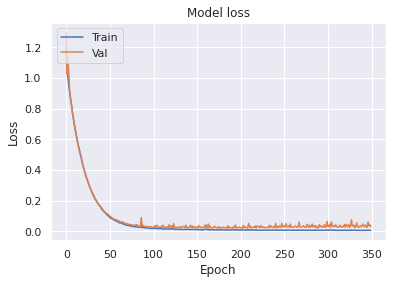

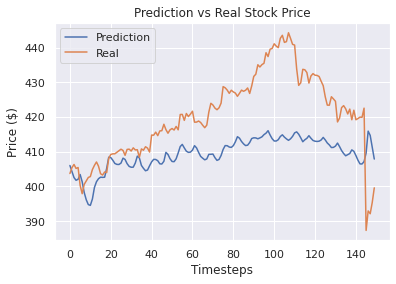

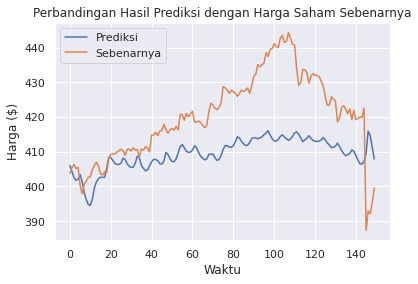

#Train Samples:  319 #Val Samples:  158
Val MAPE:  2.2345713785091816
Val Adjusted MAPE:  1.6782433846171139
Val Accuracy:  0.6993006993006993


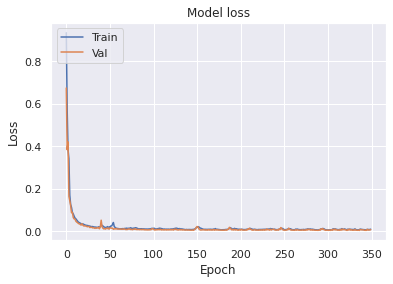

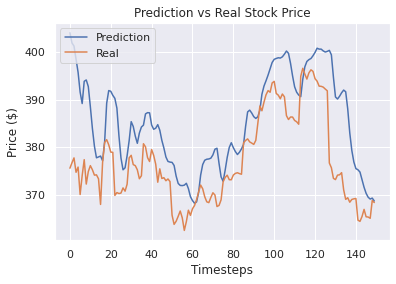

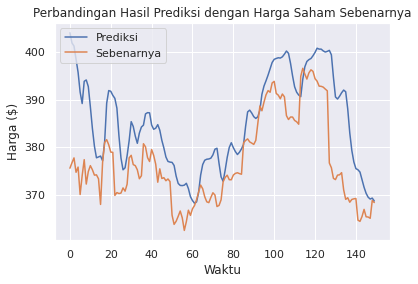

#Train Samples:  477 #Val Samples:  158
Val MAPE:  1.3379792265608499
Val Adjusted MAPE:  1.0179343911989154
Val Accuracy:  0.6713286713286714


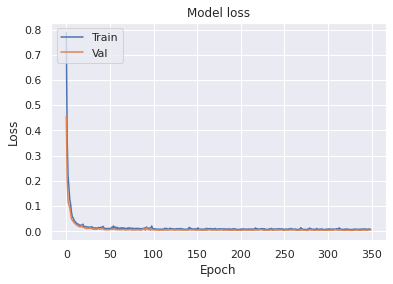

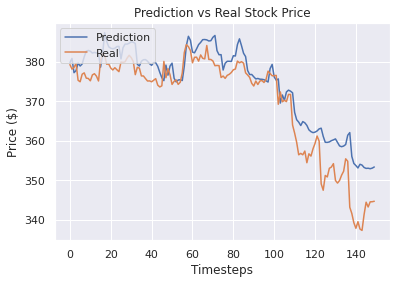

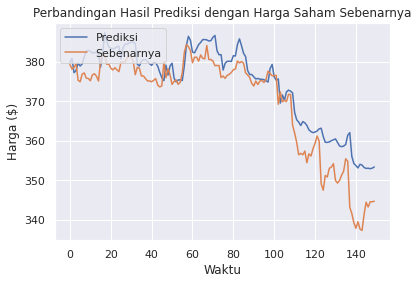

#Train Samples:  635 #Val Samples:  158
Val MAPE:  0.824399971145952
Val Adjusted MAPE:  0.5927520604303401
Val Accuracy:  0.7342657342657343


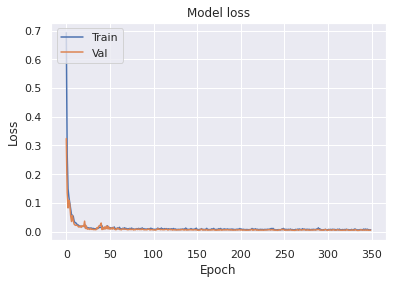

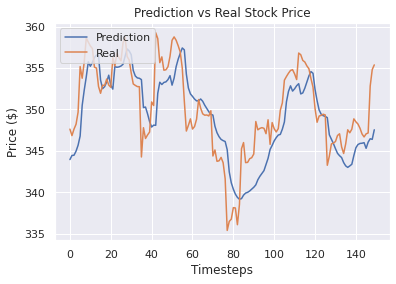

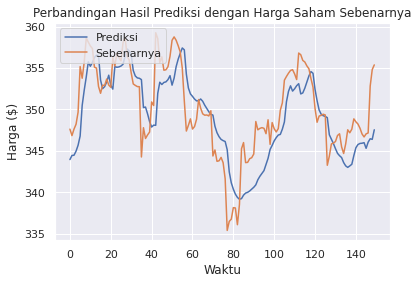

#Train Samples:  793 #Val Samples:  158
Val MAPE:  1.4293967704023172
Val Adjusted MAPE:  1.0364051110092898
Val Accuracy:  0.7692307692307693


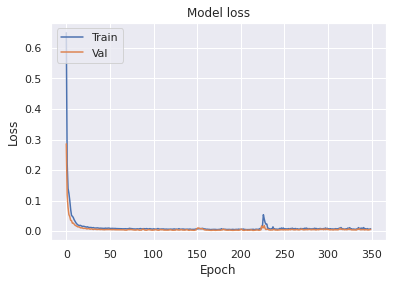

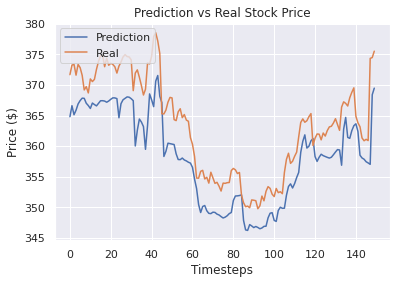

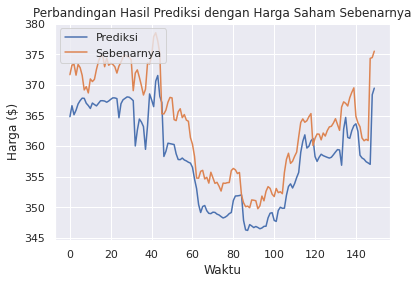

#Train Samples:  951 #Val Samples:  158
Val MAPE:  2.7370134022430532
Val Adjusted MAPE:  2.0108723609046812
Val Accuracy:  0.7342657342657343


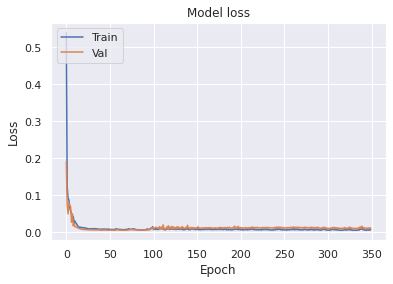

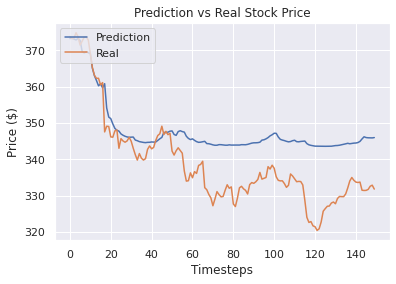

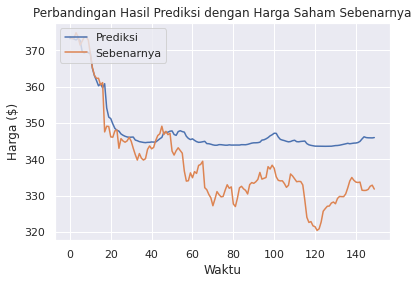

#Train Samples:  1109 #Val Samples:  158
Val MAPE:  0.9074451763494952
Val Adjusted MAPE:  0.6979294849923239
Val Accuracy:  0.8181818181818182


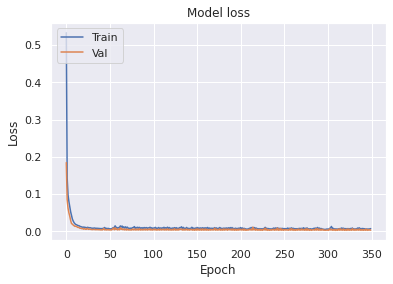

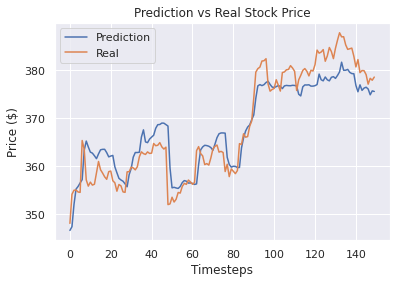

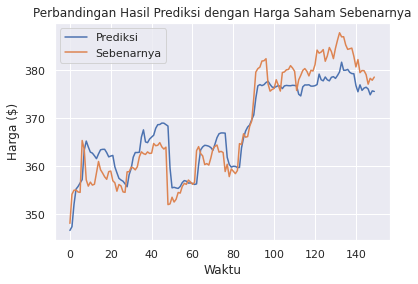

#Train Samples:  1267 #Val Samples:  158
Val MAPE:  1.303027271269678
Val Adjusted MAPE:  0.932220103087919
Val Accuracy:  0.8181818181818182


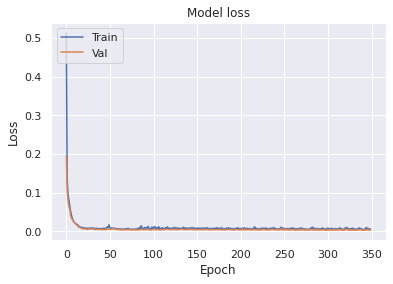

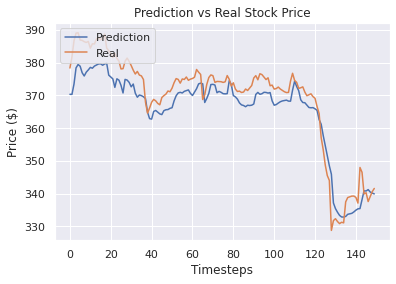

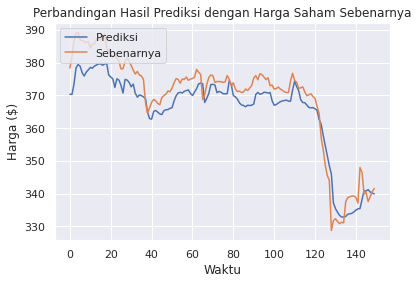

#Train Samples:  1425 #Val Samples:  158
Val MAPE:  1.5267182338202134
Val Adjusted MAPE:  1.1231586314939135
Val Accuracy:  0.7902097902097902


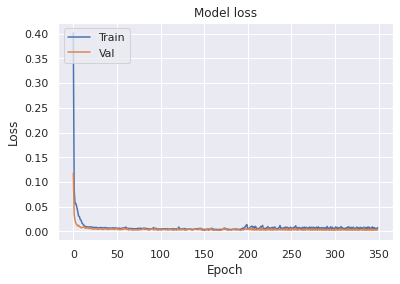

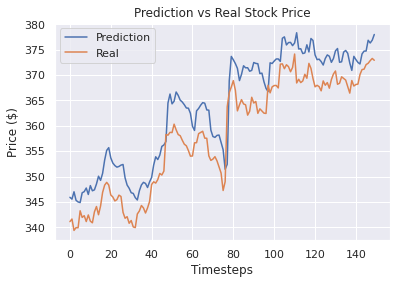

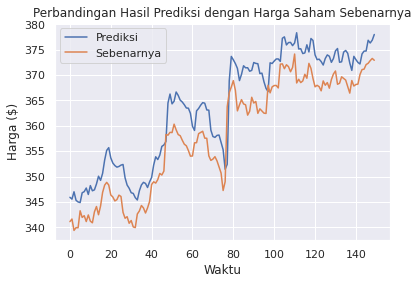

#Train Samples:  1583 #Val Samples:  158
Val MAPE:  0.7844195397881389
Val Adjusted MAPE:  0.5503814953273958
Val Accuracy:  0.7692307692307693


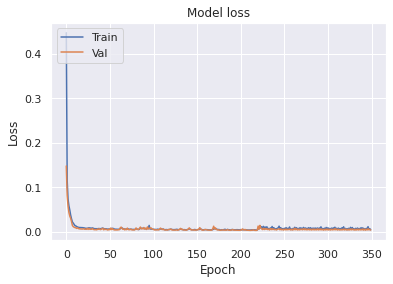

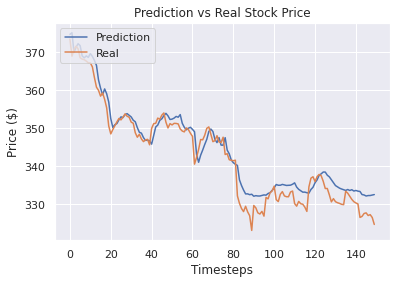

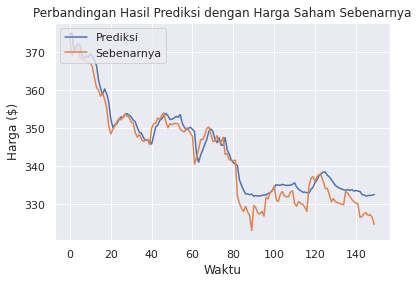

10-Fold Accuracy Test Avg Score: 0.7475524475524475, Std Score: 0.051998073972087576
10-Fold MAPE Test Avg Score: 1.5936795459708848, Std Score: 0.7210983167953218
10-Fold Adjusted MAPE Test Avg Score: 1.1879655539098306, Std Score: 0.5609127489933978
Epochs: 350
LSTM Nodes 1: 256
LSTM Nodes 2: 128
Input Dropout Rate: 0
Hidden Dropout Rate: 0.2
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f187c03c748>



In [10]:
cross_val(df,TIME_STEPS=7,BATCH_SIZE=25,n_fold=10,
          input_dropout=0,hidden_dropout=0.2,l2_regularizer=0.005,
          lstm_units_1=256,lstm_units_2=128,
          hidden_units_1=128,hidden_units_2=64,
          optimizer=optimizers.Adam(learning_rate=0.0005),
          epochs=350)